In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))


/tmp/ipykernel_3164/945712042.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import os
import argparse
from typing import Any, Callable, Sequence
from pathlib import Path
from PIL import Image
import matplotlib.image as mpimg

import jax
import jax.random as jr
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.flatten_util import ravel_pytree
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn


from bong.util import run_rebayes_algorithm, gaussian_kl_div, MLP
from bong.src import bbb, blr, bog, bong, experiment_utils
#from bong.agents import AGENT_NAMES




In [4]:
x = (42 if False else 41)
print(x)

41


In [13]:
[11*n + (n+1)*1 for n in [10,15,20,25,30,35]]

[121, 181, 241, 301, 361, 421]

In [ ]:
dir = '/teamspace/studios/this_studio/jobs/timingdlr'
df = pd.read_csv(f'{dir}/jobs.csv')
print(df.columns)

#condition = df.query('agent=="bbb_fc" and ef==0 and linplugin==0')
condition = (df['agent'] == "bbb_fc") & (df['ef'] == 0) & (df['linplugin'] == 0)

indices_to_drop = df[condition].index
df_filtered = df.drop(indices_to_drop)

print(len(df))
print(len(df_filtered))

dir = '/teamspace/studios/this_studio/jobs/timingfc4'
df_filtered.to_csv(f'{dir}/jobs.csv', index=False)

In [8]:
import os
import argparse
import os
import itertools
import pandas as pd
from pathlib import Path
import os
import datetime

def list_subdirectories(directory):
    return [name for name in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, name))]

src = '/teamspace/jobs'
dst = '/teamspace/studios/this_studio/jobs'
dirs = list_subdirectories(src)
for old_name in dirs:
    parts = old_name.split('-')
    num = parts[2]
    new_name = f'expt_timing2-{num}'
    dst_path = Path(dst, new_name, 'work')
    print(f'\n Creating {str(dst_path)}')
    dst_path.mkdir(parents=True, exist_ok=True)

    #cmd = f'mv {directory}/{old_name} {directory}/{new_name}'
    cmd = f'sudo cp -r {src}/{old_name}/work/*.* {dst}/{new_name}/work'
    print(cmd)
    os.system(cmd)


 Creating /teamspace/studios/this_studio/jobs/expt_timing2-13/work
sudo cp -r /teamspace/jobs/expt-timing2-13/work/*.* /teamspace/studios/this_studio/jobs/expt_timing2-13/work

 Creating /teamspace/studios/this_studio/jobs/expt_timing2-10/work
sudo cp -r /teamspace/jobs/expt-timing2-10/work/*.* /teamspace/studios/this_studio/jobs/expt_timing2-10/work

 Creating /teamspace/studios/this_studio/jobs/expt_timing2-02/work
sudo cp -r /teamspace/jobs/expt-timing2-02/work/*.* /teamspace/studios/this_studio/jobs/expt_timing2-02/work

 Creating /teamspace/studios/this_studio/jobs/expt_timing2-00/work
sudo cp -r /teamspace/jobs/expt-timing2-00/work/*.* /teamspace/studios/this_studio/jobs/expt_timing2-00/work

 Creating /teamspace/studios/this_studio/jobs/expt_timing2-15/work
sudo cp -r /teamspace/jobs/expt-timing2-15/work/*.* /teamspace/studios/this_studio/jobs/expt_timing2-15/work

 Creating /teamspace/studios/this_studio/jobs/expt_timing2-41/work
sudo cp -r /teamspace/jobs/expt-timing2-41/work

Saving figure to /teamspace/studios/this_studio/jobs/expt_timing//times
bong_fc_Lin0_EF0 [ 11 121] [1.49223372 7.88719506]
bog_fc_Lin0_EF0 [ 11 121] [1.4067002  4.06610123]


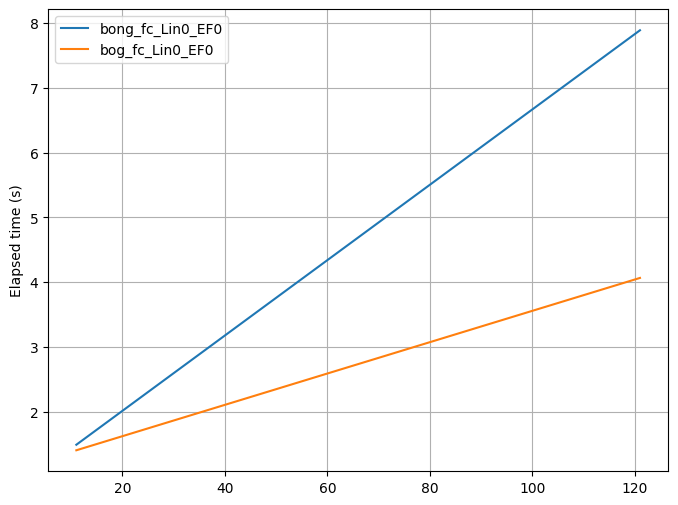

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--dir", type=str, default="/teamspace/studios/this_studio/jobs/expt_timing/")
args = parser.parse_args([])

import plot_times
fig, ax = plot_times.main(args)


In [13]:
from process_jobs import *

root_dir = '/teamspace/studios/this_studio/jobs'
data_dir = 'reg-D10-mlp_20_20_1'
model_dir = 'mlp_1'
agent_dir = 'A:bong-P:fc-Lin:0-LR:0_01-IT:10-MC:100-EF:0-R:0/'
dir = f'{root_dir}/{data_dir}/{model_dir}/{agent_dir}'



    
df = create_results_summary(dir)
df.head()





,jobname,agent_name,model_name,data_name,elapsed,summary
0,job0-00,bong_fc-MC100-I1-LR0-EF0-Lin0,mlp_1,reg-D10-mlp_20_20_1,1.406131,"Test NLL: 1.4352, NLPD: 1.4501\nVal NLL 1.436..."
